In [1]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from utils.utils import save_df, load_df, DATA, PLOTS_DIR_PATH
import matplotlib.pyplot as plt
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.go_enrichment import GOEnrichmentStudy
from goatools import obo_parser

## GO enrichment on significant DEGs

In [2]:
# 1. Download files if needed
def setup_go_data():
    if not os.path.exists(DATA / 'go-basic.obo'):
        download_go_basic_obo()
        os.rename('go-basic.obo', DATA / 'go-basic.obo')
    if not os.path.exists(DATA / 'gene2go'):
        download_ncbi_associations()
        os.rename('gene2go', DATA / 'gene2go')
        
obodag = GODag(os.path.join(DATA, 'go-basic.obo'))

# 2. Load data and prepare gene sets
def prepare_data():
    dds_results = pd.read_csv(os.path.join(DATA, 'statistical_results_hypochondriacus_caudatus_df.csv'), index_col=0)
    
    # Gene sets
    foreground = dds_results[(dds_results['padj'] < 0.05) & 
                           (abs(dds_results['log2FoldChange']) > 1)].index.tolist()
    background = dds_results.index.tolist()
    
    return dds_results, foreground, background

# 3. Load GO annotations # different to the version below!
def load_go_annotations(dds_results):
    id_to_go = defaultdict(set)
    with open(os.path.join(DATA, 'eggnog_GOs.txt'), 'r') as f:
        for line in f:
            if line.strip() and not line.startswith('#'):
                parts = line.split(' ', 1)
                base_id = parts[0].split('.')[0]  # Get base ID without version
                if len(parts) > 1 and parts[1] != '-':
                    # Add GO terms to the existing set for this base ID
                    id_to_go[base_id].update(go_term.strip() for go_term in parts[1].split(','))
    
    dds_results['go_terms'] = dds_results.index.map(lambda x: list(id_to_go.get(x, set())))
    print(f"Assigned GO terms to {sum(dds_results['go_terms'].str.len() > 0)} of {len(dds_results)} genes")
    return {gene: set(gos) for gene, gos in dds_results.go_terms.items()}

# 4. Run GO enrichment
def run_go_enrichment(background, gene2go, foreground):
    obodag = obo_parser.GODag(os.path.join(DATA, 'go-basic.obo'))
    
    go_study = GOEnrichmentStudy(
        background, gene2go, obodag,
        propagate_counts=False,
        alpha=0.05,
        methods=['fdr_bh']
    )
    return go_study.run_study(foreground)

# 5. Process and display results
def process_results(go_results, obodag):
    go_df = pd.DataFrame([{
        "GO": r.GO, "name": r.name,
        "namespace": obodag[r.GO].namespace,
        "p_fdr_bh": r.p_fdr_bh,
        "ratio_in_study": (r.study_count, r.ratio_in_study[1]),
        "ratio_in_pop": (r.pop_count, r.ratio_in_pop[1])
    } for r in go_results])
    
    go_df["ratio_in_study_value"] = go_df["ratio_in_study"].apply(lambda x: x[0]/x[1])
    go_df["ratio_in_pop_value"] = go_df["ratio_in_pop"].apply(lambda x: x[0]/x[1])
    
    return go_df[
        (go_df["p_fdr_bh"] < 0.05) & 
        (go_df["ratio_in_study_value"] > go_df["ratio_in_pop_value"])
    ]

# Main execution
if __name__ == "__main__":
    setup_go_data()
    dds_results, foreground, background = prepare_data()
    gene2go = load_go_annotations(dds_results)
    go_results = run_go_enrichment(background, gene2go, foreground)
    enriched_terms = process_results(go_results, obodag)
    
    print(enriched_terms[["GO", "name", "namespace", "p_fdr_bh", 
                         "ratio_in_study_value", "ratio_in_pop_value"]])

/Users/timockenga/Programming/deseq2_amaranth_hypochondriacus_caudatus/data/go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms
Assigned GO terms to 18274 of 19499 genes
/Users/timockenga/Programming/deseq2_amaranth_hypochondriacus_caudatus/data/go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms

Load  Ontology Enrichment Analysis ...
100% 19,499 of 19,499 population items found in association

Runing  Ontology Analysis: current study set of 3683 IDs.
100%  3,683 of  3,683 study items found in association
100%  3,683 of  3,683 study items found in population(19499)
Calculating 10,393 uncorrected p-values using fisher_scipy_stats
  10,393 terms are associated with 10,719 of 19,499 population items
   5,581 terms are associated with  1,740 of  3,683 study items
  METHOD fdr_bh:
     184 GO terms found significant (< 0.05=alpha) ( 10 enriched + 174 purified): statsmodels fdr_bh
     247 study items associated with significant GO IDs (enriched)
   1,740 study items associated with signifi

In [3]:
# Save results
enriched_terms.to_csv(os.path.join(DATA, "enriched_terms_results_all_DEG.csv"), index=False)

In [4]:
load_df('enriched_terms_results_all_DEG.csv')

,name,namespace,p_fdr_bh,ratio_in_study,ratio_in_pop,ratio_in_study_value,ratio_in_pop_value
GO,,,,,,,
GO:0044550,secondary metabolite biosynthetic process,biological_process,0.000096,"(54, 3683)","(150, 19499)",0.014662,0.007693
GO:0010143,cutin biosynthetic process,biological_process,0.000204,"(16, 3683)","(26, 19499)",0.004344,0.001333
GO:0019748,secondary metabolic process,biological_process,0.008680,"(65, 3683)","(220, 19499)",0.017649,0.011283
GO:0006260,DNA replication,biological_process,0.012278,"(39, 3683)","(116, 19499)",0.010589,0.005949
GO:0006268,DNA unwinding involved in DNA replication,biological_process,0.014376,"(7, 3683)","(9, 19499)",0.001901,0.000462
GO:0071491,cellular response to red light,biological_process,0.024174,"(8, 3683)","(12, 19499)",0.002172,0.000615
GO:0010161,red light signaling pathway,biological_process,0.034886,"(7, 3683)","(10, 19499)",0.001901,0.000513
GO:0016709,"oxidoreductase activity, acting on paired dono...",molecular_function,0.001554,"(29, 3683)","(70, 19499)",0.007874,0.003590
GO:0004497,monooxygenase activity,molecular_function,0.008250,"(38, 3683)","(110, 19499)",0.010318,0.005641


In [5]:
def plot_go_terms(go_df, top_n=9):
    # Sort and pick top N
    top_terms = go_df.sort_values("p_fdr_bh").head(top_n).copy()

    # Truncate long names
    top_terms["name_short"] = top_terms["name"].apply(lambda x: x if len(x) <= 50 else x[:47] + "...")

    # Color map for namespaces
    namespace_colors = {
        'biological_process': 'skyblue',
        'molecular_function': 'lightgreen',
        'cellular_component': 'lightcoral'
    }
    colors = top_terms["namespace"].map(namespace_colors)

    # Plot
    plt.figure(figsize=(9, 6))
    bars = plt.barh(top_terms["name_short"], -np.log10(top_terms["p_fdr_bh"]), color=colors)
    plt.xlabel("-log10(FDR)", fontsize=14)
    plt.ylabel("GO Term", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.gca().invert_yaxis()
    plt.tight_layout()

    # Add legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in namespace_colors.values()]
    labels = list(namespace_colors.keys())
    plt.legend(handles, labels, title="GO Namespace", loc="lower right")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR_PATH, 'significatn_GO_terms_1.pdf'), bbox_inches="tight")
    plt.show()

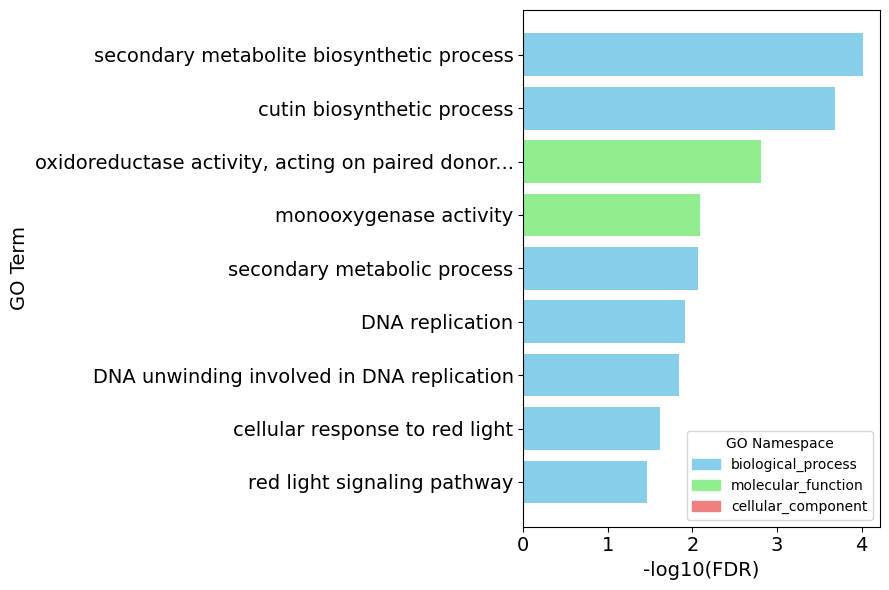

In [6]:
plot_go_terms(enriched_terms)

## A.hypochondriacus

In [7]:
# 1. Download files if needed
def setup_go_data():
    if not os.path.exists(DATA / 'go-basic.obo'):
        download_go_basic_obo()
        os.rename('go-basic.obo', DATA / 'go-basic.obo')
    if not os.path.exists(DATA / 'gene2go'):
        download_ncbi_associations()
        os.rename('gene2go', DATA / 'gene2go')
        
obodag = GODag(os.path.join(DATA, 'go-basic.obo'))

# 2. Load data and prepare gene sets
def prepare_data():
    dds_results = pd.read_csv(os.path.join(DATA, 'statistical_results_hypochondriacus_caudatus_df.csv'), index_col=0)
    
    # Gene sets
    foreground = dds_results[
    (dds_results['padj'] < 0.05) &
    (abs(dds_results['log2FoldChange']) > 1) &
    (dds_results['log2FoldChange'] > 0)
].index.tolist()
    
    background = dds_results.index.tolist()
    
    return dds_results, foreground, background

# 3. Load GO annotations # different to the version below!
def load_go_annotations(dds_results):
    id_to_go = defaultdict(set)
    with open(os.path.join(DATA, 'eggnog_GOs.txt'), 'r') as f:
        for line in f:
            if line.strip() and not line.startswith('#'):
                parts = line.split(' ', 1)
                base_id = parts[0].split('.')[0]  # Get base ID without version
                if len(parts) > 1 and parts[1] != '-':
                    # Add GO terms to the existing set for this base ID
                    id_to_go[base_id].update(go_term.strip() for go_term in parts[1].split(','))
    
    dds_results['go_terms'] = dds_results.index.map(lambda x: list(id_to_go.get(x, set())))
    print(f"Assigned GO terms to {sum(dds_results['go_terms'].str.len() > 0)} of {len(dds_results)} genes")
    return {gene: set(gos) for gene, gos in dds_results.go_terms.items()}

# 4. Run GO enrichment
def run_go_enrichment(background, gene2go, foreground):
    obodag = obo_parser.GODag(os.path.join(DATA, 'go-basic.obo'))
    
    go_study = GOEnrichmentStudy(
        background, gene2go, obodag,
        propagate_counts=False,
        alpha=0.05,
        methods=['fdr_bh']
    )
    return go_study.run_study(foreground)

# 5. Process and display results
def process_results(go_results, obodag):
    go_df = pd.DataFrame([{
        "GO": r.GO, "name": r.name,
        "namespace": obodag[r.GO].namespace,
        "p_fdr_bh": r.p_fdr_bh,
        "ratio_in_study": (r.study_count, r.ratio_in_study[1]),
        "ratio_in_pop": (r.pop_count, r.ratio_in_pop[1])
    } for r in go_results])
    
    go_df["ratio_in_study_value"] = go_df["ratio_in_study"].apply(lambda x: x[0]/x[1])
    go_df["ratio_in_pop_value"] = go_df["ratio_in_pop"].apply(lambda x: x[0]/x[1])
    
    return go_df[
        (go_df["p_fdr_bh"] < 0.05) & 
        (go_df["ratio_in_study_value"] > go_df["ratio_in_pop_value"])
    ]

# Main execution
if __name__ == "__main__":
    setup_go_data()
    dds_results, foreground, background = prepare_data()
    gene2go = load_go_annotations(dds_results)
    go_results = run_go_enrichment(background, gene2go, foreground)
    enriched_terms_hypochondriacus = process_results(go_results, obodag)
    
    print(enriched_terms_hypochondriacus[["GO", "name", "namespace", "p_fdr_bh", 
                         "ratio_in_study_value", "ratio_in_pop_value"]])

/Users/timockenga/Programming/deseq2_amaranth_hypochondriacus_caudatus/data/go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms
Assigned GO terms to 18274 of 19499 genes
/Users/timockenga/Programming/deseq2_amaranth_hypochondriacus_caudatus/data/go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms

Load  Ontology Enrichment Analysis ...
100% 19,499 of 19,499 population items found in association

Runing  Ontology Analysis: current study set of 1538 IDs.
100%  1,538 of  1,538 study items found in association
100%  1,538 of  1,538 study items found in population(19499)
Calculating 10,393 uncorrected p-values using fisher_scipy_stats
  10,393 terms are associated with 10,719 of 19,499 population items
   4,010 terms are associated with    672 of  1,538 study items
  METHOD fdr_bh:
      50 GO terms found significant (< 0.05=alpha) (  5 enriched +  45 purified): statsmodels fdr_bh
      36 study items associated with significant GO IDs (enriched)
     672 study items associated with signifi

In [8]:
# Save results
enriched_terms_hypochondriacus.to_csv("../data/enriched_terms_results_hypochondriacus.csv", index=False)

In [9]:
load_df("enriched_terms_results_hypochondriacus.csv")

,name,namespace,p_fdr_bh,ratio_in_study,ratio_in_pop,ratio_in_study_value,ratio_in_pop_value
GO,,,,,,,
GO:0071491,cellular response to red light,biological_process,0.032838,"(6, 1538)","(12, 19499)",0.003901,0.000615
GO:0005681,spliceosomal complex,cellular_component,0.009141,"(22, 1538)","(107, 19499)",0.014304,0.005487
GO:0071013,catalytic step 2 spliceosome,cellular_component,0.046804,"(13, 1538)","(54, 19499)",0.008453,0.002769
GO:0016679,"oxidoreductase activity, acting on diphenols a...",molecular_function,0.027186,"(8, 1538)","(21, 19499)",0.005202,0.001077
GO:0016682,"oxidoreductase activity, acting on diphenols a...",molecular_function,0.027186,"(8, 1538)","(21, 19499)",0.005202,0.001077


In [10]:
def plot_go_terms_hypochondriacus(go_df, top_n=5):
    # Sort and pick top N
    top_terms = go_df.sort_values("p_fdr_bh").head(top_n).copy()

    # Truncate long names
    top_terms["name_short"] = top_terms["name"].apply(lambda x: x if len(x) <= 50 else x[:47] + "...")

    # Color map for namespaces
    namespace_colors = {
        'biological_process': 'skyblue',
        'molecular_function': 'lightgreen',
        'cellular_component': 'lightcoral'
    }
    colors = top_terms["namespace"].map(namespace_colors)

    # Plot
    plt.figure(figsize=(9, 6))
    bars = plt.barh(top_terms["name_short"], -np.log10(top_terms["p_fdr_bh"]), color=colors)
    plt.xlabel("-log10(FDR)", fontsize=14)
    plt.ylabel("GO Term", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.gca().invert_yaxis()
    plt.tight_layout()

    # Add legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in namespace_colors.values()]
    labels = list(namespace_colors.keys())
    plt.legend(handles, labels, title="GO Namespace", loc="lower right")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR_PATH, 'significatn_GO_terms_hypochondriacus_1.pdf'), bbox_inches="tight")
    plt.show()

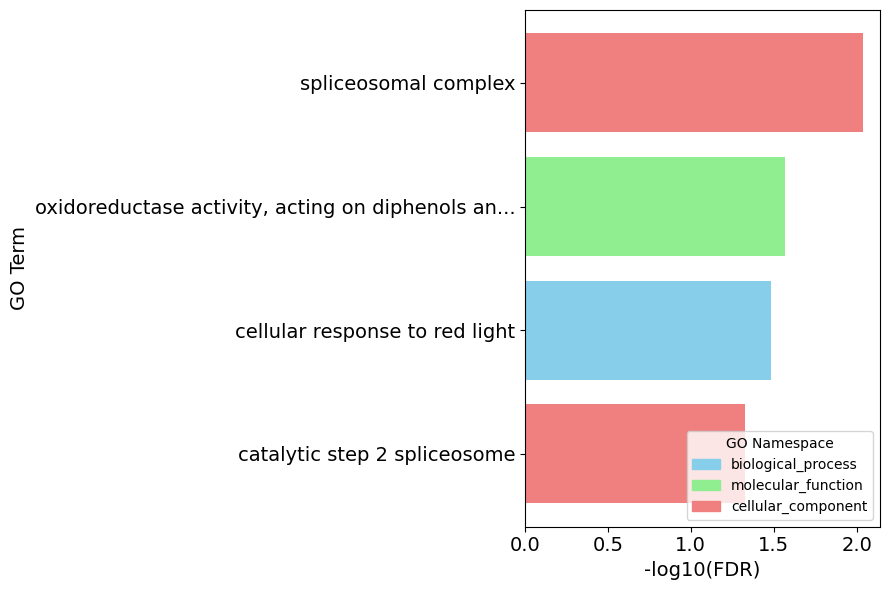

In [11]:
plot_go_terms_hypochondriacus(enriched_terms_hypochondriacus)


## A. caudatus

In [12]:
# 1. Download files if needed
def setup_go_data():
    if not os.path.exists(DATA / 'go-basic.obo'):
        download_go_basic_obo()
        os.rename('go-basic.obo', DATA / 'go-basic.obo')
    if not os.path.exists(DATA / 'gene2go'):
        download_ncbi_associations()
        os.rename('gene2go', DATA / 'gene2go')
        
obodag = GODag(os.path.join(DATA, 'go-basic.obo'))

# 2. Load data and prepare gene sets
def prepare_data():
    dds_results = pd.read_csv(os.path.join(DATA, 'statistical_results_hypochondriacus_caudatus_df.csv'), index_col=0)
    
   # Gene sets
    foreground = dds_results[
    (dds_results['padj'] < 0.05) &
    (abs(dds_results['log2FoldChange']) > 1) &
    (dds_results['log2FoldChange'] < 0)
].index.tolist()
    background = dds_results.index.tolist()
    
    return dds_results, foreground, background

# 3. Load GO annotations # different to the version below!
def load_go_annotations(dds_results):
    id_to_go = defaultdict(set)
    with open(os.path.join(DATA, 'eggnog_GOs.txt'), 'r') as f:
        for line in f:
            if line.strip() and not line.startswith('#'):
                parts = line.split(' ', 1)
                base_id = parts[0].split('.')[0]  # Get base ID without version
                if len(parts) > 1 and parts[1] != '-':
                    # Add GO terms to the existing set for this base ID
                    id_to_go[base_id].update(go_term.strip() for go_term in parts[1].split(','))
    
    dds_results['go_terms'] = dds_results.index.map(lambda x: list(id_to_go.get(x, set())))
    print(f"Assigned GO terms to {sum(dds_results['go_terms'].str.len() > 0)} of {len(dds_results)} genes")
    return {gene: set(gos) for gene, gos in dds_results.go_terms.items()}

# 4. Run GO enrichment
def run_go_enrichment(background, gene2go, foreground):
    obodag = obo_parser.GODag(os.path.join(DATA, 'go-basic.obo'))
    
    go_study = GOEnrichmentStudy(
        background, gene2go, obodag,
        propagate_counts=False,
        alpha=0.05,
        methods=['fdr_bh']
    )
    return go_study.run_study(foreground)

# 5. Process and display results
def process_results(go_results, obodag):
    go_df = pd.DataFrame([{
        "GO": r.GO, "name": r.name,
        "namespace": obodag[r.GO].namespace,
        "p_fdr_bh": r.p_fdr_bh,
        "ratio_in_study": (r.study_count, r.ratio_in_study[1]),
        "ratio_in_pop": (r.pop_count, r.ratio_in_pop[1])
    } for r in go_results])
    
    go_df["ratio_in_study_value"] = go_df["ratio_in_study"].apply(lambda x: x[0]/x[1])
    go_df["ratio_in_pop_value"] = go_df["ratio_in_pop"].apply(lambda x: x[0]/x[1])
    
    return go_df[
        (go_df["p_fdr_bh"] < 0.05) & 
        (go_df["ratio_in_study_value"] > go_df["ratio_in_pop_value"])
    ]

# Main execution
if __name__ == "__main__":
    setup_go_data()
    dds_results, foreground, background = prepare_data()
    gene2go = load_go_annotations(dds_results)
    go_results = run_go_enrichment(background, gene2go, foreground)
    enriched_terms_caudatus = process_results(go_results, obodag)
    
    print(enriched_terms_caudatus[["GO", "name", "namespace", "p_fdr_bh", 
                         "ratio_in_study_value", "ratio_in_pop_value"]])

/Users/timockenga/Programming/deseq2_amaranth_hypochondriacus_caudatus/data/go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms
Assigned GO terms to 18274 of 19499 genes
/Users/timockenga/Programming/deseq2_amaranth_hypochondriacus_caudatus/data/go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms

Load  Ontology Enrichment Analysis ...
100% 19,499 of 19,499 population items found in association

Runing  Ontology Analysis: current study set of 2145 IDs.
100%  2,145 of  2,145 study items found in association
100%  2,145 of  2,145 study items found in population(19499)
Calculating 10,393 uncorrected p-values using fisher_scipy_stats
  10,393 terms are associated with 10,719 of 19,499 population items
   4,168 terms are associated with  1,068 of  2,145 study items
  METHOD fdr_bh:
     185 GO terms found significant (< 0.05=alpha) ( 23 enriched + 162 purified): statsmodels fdr_bh
     494 study items associated with significant GO IDs (enriched)
   1,068 study items associated with signifi

In [13]:
# Save results
enriched_terms_caudatus.to_csv(os.path.join(DATA, "enriched_terms_results_caudatus.csv"), index=False)

In [14]:
load_df("enriched_terms_results_caudatus.csv")

,name,namespace,p_fdr_bh,ratio_in_study,ratio_in_pop,ratio_in_study_value,ratio_in_pop_value
GO,,,,,,,
GO:0006260,DNA replication,biological_process,0.001738,"(29, 2145)","(116, 19499)",0.013520,0.005949
GO:0009664,plant-type cell wall organization,biological_process,0.003712,"(25, 2145)","(96, 19499)",0.011655,0.004923
GO:0009699,phenylpropanoid biosynthetic process,biological_process,0.006089,"(21, 2145)","(78, 19499)",0.009790,0.004000
GO:0010166,wax metabolic process,biological_process,0.006648,"(12, 2145)","(32, 19499)",0.005594,0.001641
GO:0006268,DNA unwinding involved in DNA replication,biological_process,0.008537,"(6, 2145)","(9, 19499)",0.002797,0.000462
GO:0009694,jasmonic acid metabolic process,biological_process,0.012681,"(10, 2145)","(25, 19499)",0.004662,0.001282
GO:0044550,secondary metabolite biosynthetic process,biological_process,0.014401,"(32, 2145)","(150, 19499)",0.014918,0.007693
GO:0010143,cutin biosynthetic process,biological_process,0.017370,"(10, 2145)","(26, 19499)",0.004662,0.001333
GO:0071554,cell wall organization or biogenesis,biological_process,0.021112,"(55, 2145)","(309, 19499)",0.025641,0.015847


In [15]:
def plot_go_terms_caudatus(go_df, top_n=27):
    # Sort and pick top N
    top_terms = go_df.sort_values("p_fdr_bh").head(top_n).copy()

    # Truncate long names
    top_terms["name_short"] = top_terms["name"].apply(lambda x: x if len(x) <= 50 else x[:47] + "...")

    # Color map for namespaces
    namespace_colors = {
        'biological_process': 'skyblue',
        'molecular_function': 'lightgreen',
        'cellular_component': 'lightcoral'
    }
    colors = top_terms["namespace"].map(namespace_colors)

    # Plot
    plt.figure(figsize=(9, 6))
    bars = plt.barh(top_terms["name_short"], -np.log10(top_terms["p_fdr_bh"]), color=colors)
    plt.xlabel("-log10(FDR)", fontsize=14)
    plt.ylabel("GO Term", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.gca().invert_yaxis()
    plt.tight_layout()

    # Add legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in namespace_colors.values()]
    labels = list(namespace_colors.keys())
    plt.legend(handles, labels, title="GO Namespace", loc="lower right")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR_PATH, 'significatn_GO_terms_caudatus_1.pdf'), bbox_inches="tight")
    plt.show()

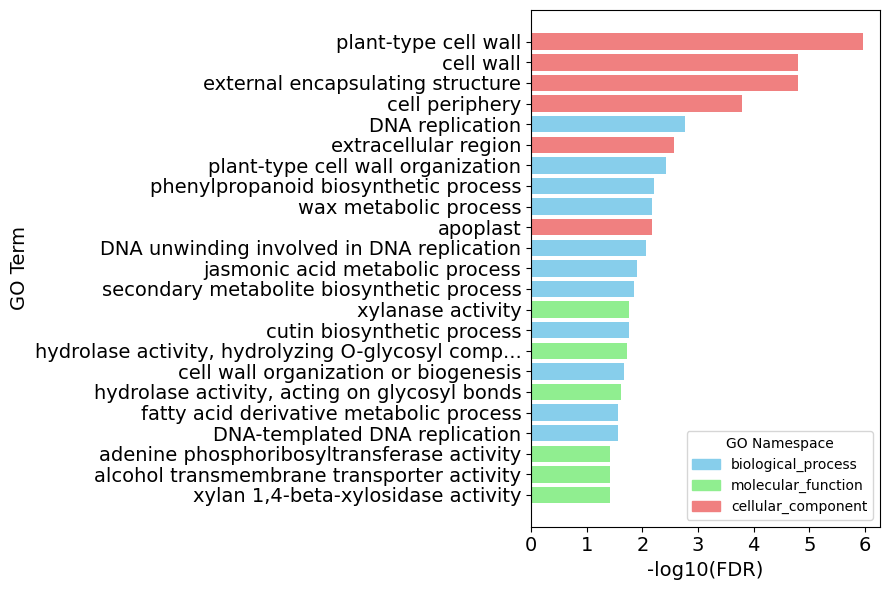

In [16]:
plot_go_terms_caudatus(enriched_terms_caudatus)